In [1]:
import numpy as np
import matplotlib.pyplot as plt

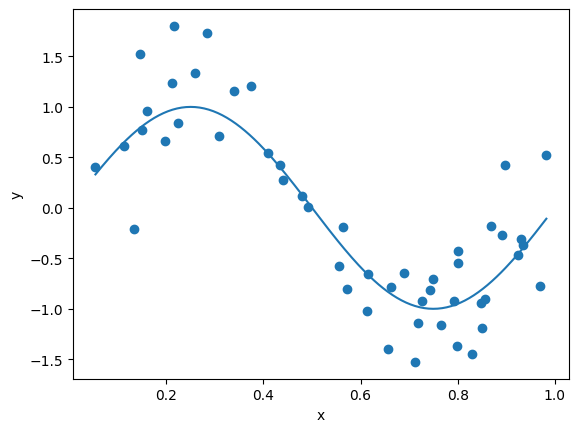

In [122]:
# set up sinusoidal data with Gaussian noise
n = 50
sig_noise = 0.4

# uniform sampling of x
# x = np.linspace(0., 1., n)

# random sampling of x
xrng = np.random.default_rng(seed=767)
x = xrng.random(n)

# add noise to y
dyrng = np.random.default_rng(seed=629)
dy = dyrng.normal(loc=0,scale=sig_noise,size=n)
y = np.sin(2*np.pi*x) + dy

# also plot underlying sin function
xtrue = np.linspace(x.min(), x.max(), 200)
ytrue = np.sin(2*np.pi*xtrue)

# make plots
plt.scatter(x,y)
plt.plot(xtrue,ytrue)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

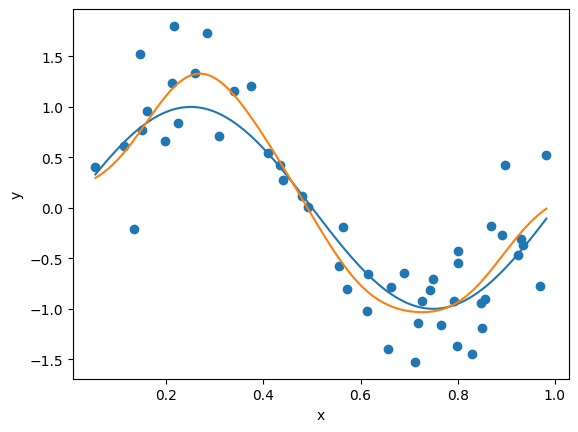

In [123]:
# set up linear model with Gaussian basis functions of fixed width and regularization parameter
s = .1
lam = .1

# un-normalized Gaussian 
def gauss(x0,mu,sig):
    return np.exp(-((x0-mu)**2)/(2*(sig**2)))

# define linear model
def yhat(xCol,wCol,muCol,sig):   
    sum = np.zeros_like(xCol)
    for i in range(np.size(xCol)):  
        sum[i] = wCol[0]     
        for j in range(1,np.size(wCol)):
            if j > 0:
                sum[i] += wCol[j]*gauss(xCol[i],muCol[j-1],sig)
            else:
                sum[i] += wCol[j]
    return sum

# calculate design matrix
dmat = np.zeros((n,n+1))
for i in range(n):
    for j in range(n+1):
        if j > 0:
            dmat[i,j] = gauss(x[i],x[j-1],s)
        else:
            dmat[i,j] = 1

# calculate weights using regularized Moore-Penrose pseudo-inverse
w = np.matmul(np.matmul(np.linalg.inv((np.matmul(dmat.T,dmat))+np.identity(n+1)*lam).T,dmat.T),y)
xfit = np.linspace(x.min(), x.max(), 200)
yfit = yhat(xfit,w,x,s)

# plot the fit vs the original function
plt.plot(xtrue,ytrue)
plt.scatter(x,y)
plt.plot(xfit,yfit)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

[[-1.86837738  2.62213785  0.31050959]
 [-1.12997408 -1.36112369  1.27659668]]
[[-2.09880493  2.10639331 -2.99309677]
 [-1.06944068 -2.72294116  5.40663744]]
[ 2.57444179  0.22570795  0.02532584 -0.52762022]
[ 1.78726669  0.87661182 -2.39273057 -2.28450137]


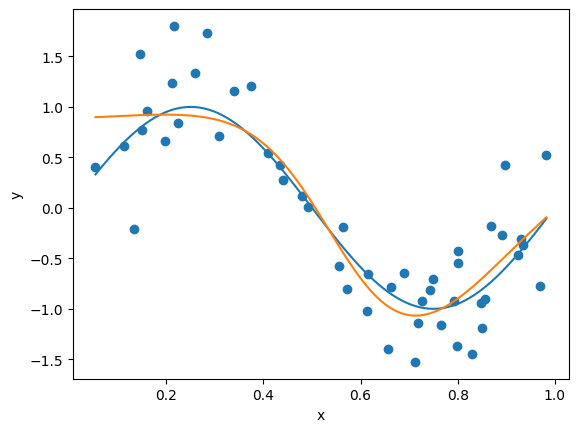

In [126]:
# sample training data for SGD
data = np.vstack((x, y)).T
nNN = 1000*n
dataNNrng = np.random.default_rng(seed=611)
dataNN = dataNNrng.choice(data, nNN)

# train NN with learning rate
eta = 0.01

# set up two-layer MLP with hidden nodes
nodes = 3   

# randomly initialize weights
w1rng = np.random.default_rng(seed=5772)
w1 = (w1rng.random((2,nodes))*6)-3
w2rng = np.random.default_rng(seed=32172)
w2 = (w2rng.random(nodes+1)*6)-3

# keep record of weights for each interation
w1Rec = np.zeros((nNN+1,2,nodes))
w1Rec[0] = w1
w2Rec = np.zeros((nNN+1,nodes+1))
w2Rec[0] = w2

for i in range(nNN):
    # forward propagation
    z = np.zeros(nodes+1)  
    z[0] = 1
    sum = w2[0]
    for j in range(1,nodes+1):
        a = w1[0,j-1]+(w1[1,j-1]*dataNN[i,0])
        z[j] = np.tanh(a)
        sum += w2[j]*z[j]

    # start backprop with error of final prediction
    delFin = sum - dataNN[i,1]
    for j in range(nodes+1):        
        # update second layer
        w2[j] += -eta*delFin*z[j]
        # get error for hidden unit
        delHid = (1-(z[j]**2))*w2[j]*delFin
        # now first layer
        if (j>0):
            w1[0,j-1] += -eta*delHid
            w1[1,j-1] += -eta*delHid*dataNN[i,0]
        
    w1Rec[i+1] = w1
    w2Rec[i+1] = w2

# each node takes bias and weighted linear input, sum nodes plus second bias for output
def yhatNN(x1,w1Col,w2Col):
    sum = w2Col[0]
    for j in range(1,np.size(w2Col)):
        sum += w2Col[j]*np.tanh(w1Col[0,j-1]+(w1Col[1,j-1]*x1))
    return sum 

print(w1Rec[0])
print(w1)
print(w2Rec[0])
print(w2)

# ploy final fit in training data range
xfitNN = np.linspace(x.min(), x.max(), 200)
yfitNN = yhatNN(xfit,w1,w2)

# plot the fit vs the original function
plt.plot(xtrue,ytrue)
plt.scatter(x,y)
plt.plot(xfitNN,yfitNN)
plt.xlabel("x")
plt.ylabel("y")
plt.show()      

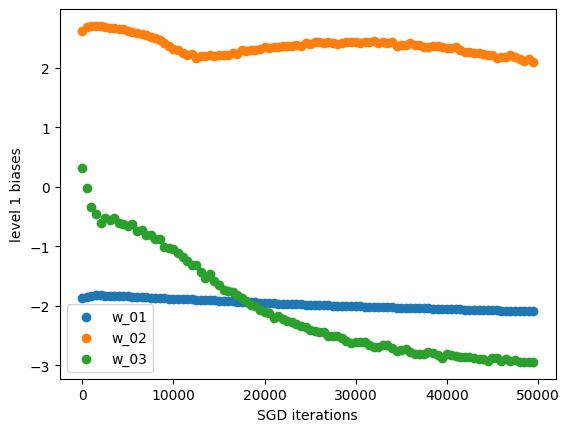

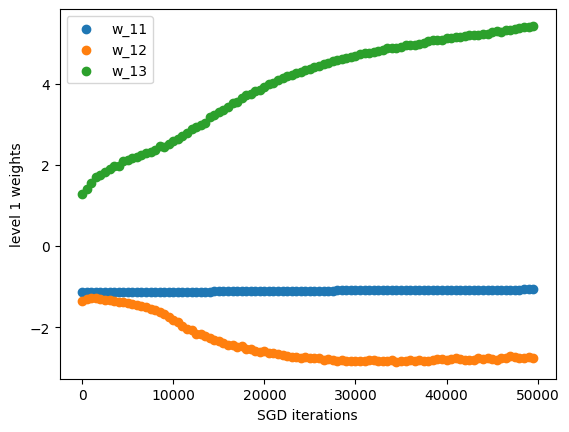

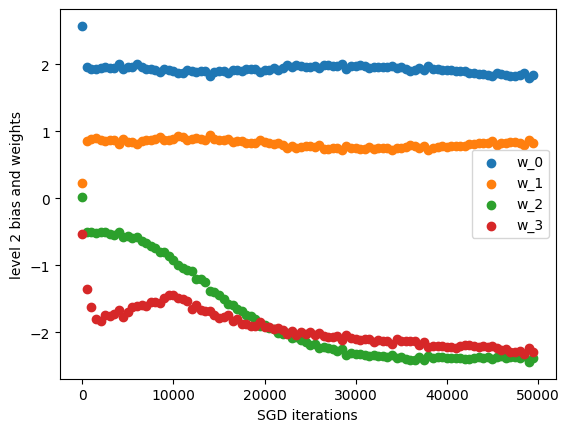

In [127]:
# NN weights as function of SGD iterations
nWeightPlot = 100
w1_01_Plot = np.zeros((nWeightPlot,2))
w1_02_Plot = np.zeros((nWeightPlot,2))
w1_03_Plot = np.zeros((nWeightPlot,2))
w1_11_Plot = np.zeros((nWeightPlot,2))
w1_12_Plot = np.zeros((nWeightPlot,2))
w1_13_Plot = np.zeros((nWeightPlot,2))
w2_0_Plot = np.zeros((nWeightPlot,2))
w2_1_Plot = np.zeros((nWeightPlot,2))
w2_2_Plot = np.zeros((nWeightPlot,2))
w2_3_Plot = np.zeros((nWeightPlot,2))

j = 0
for i in range(nNN):
    if (i%(nNN/nWeightPlot)==0):
        
        w1_01_Plot[j] = np.array((i,w1Rec[i,0,0]))
        w1_02_Plot[j] = np.array((i,w1Rec[i,0,1]))
        w1_03_Plot[j] = np.array((i,w1Rec[i,0,2]))
        w1_11_Plot[j] = np.array((i,w1Rec[i,1,0]))
        w1_12_Plot[j] = np.array((i,w1Rec[i,1,1]))
        w1_13_Plot[j] = np.array((i,w1Rec[i,1,2]))
        w2_0_Plot[j] = np.array((i,w2Rec[i,0]))
        w2_1_Plot[j] = np.array((i,w2Rec[i,1]))
        w2_2_Plot[j] = np.array((i,w2Rec[i,2]))
        w2_3_Plot[j] = np.array((i,w2Rec[i,3]))
        
        j += 1
        if (j == nWeightPlot):
            break

# plot the weights
plt.scatter(w1_01_Plot[:,0],w1_01_Plot[:,1], label = 'w_01')
plt.scatter(w1_02_Plot[:,0],w1_02_Plot[:,1], label = 'w_02')
plt.scatter(w1_03_Plot[:,0],w1_03_Plot[:,1], label = 'w_03')
plt.xlabel("SGD iterations")
plt.ylabel("level 1 biases")
plt.legend(loc='best')
plt.show() 

plt.scatter(w1_11_Plot[:,0],w1_11_Plot[:,1], label = 'w_11')
plt.scatter(w1_12_Plot[:,0],w1_12_Plot[:,1], label = 'w_12')
plt.scatter(w1_13_Plot[:,0],w1_13_Plot[:,1], label = 'w_13')
plt.xlabel("SGD iterations")
plt.ylabel("level 1 weights")
plt.legend(loc='best')
plt.show() 

plt.scatter(w2_0_Plot[:,0],w2_0_Plot[:,1], label = 'w_0')
plt.scatter(w2_1_Plot[:,0],w2_1_Plot[:,1], label = 'w_1')
plt.scatter(w2_2_Plot[:,0],w2_2_Plot[:,1], label = 'w_2')
plt.scatter(w2_3_Plot[:,0],w2_3_Plot[:,1], label = 'w_3')
plt.xlabel("SGD iterations")
plt.ylabel("level 2 bias and weights")
plt.legend(loc='best')
plt.show() 

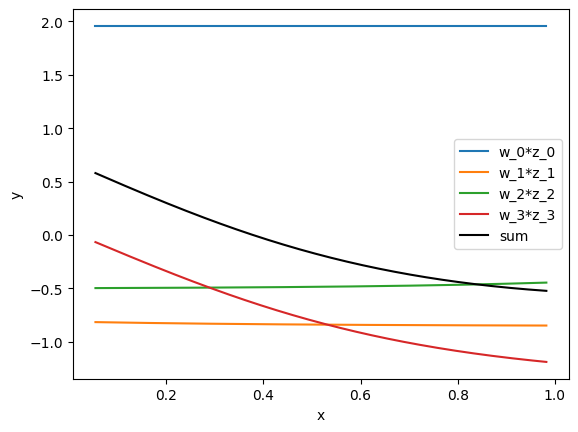

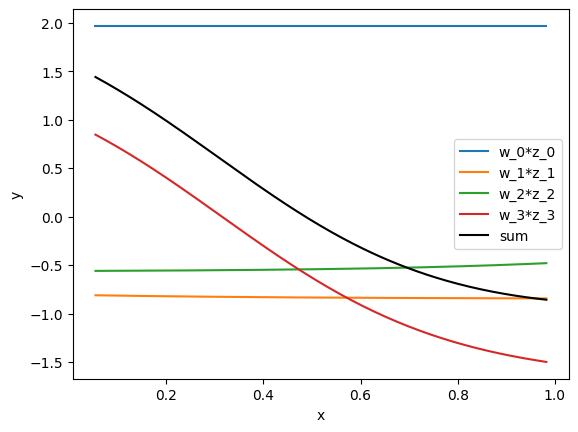

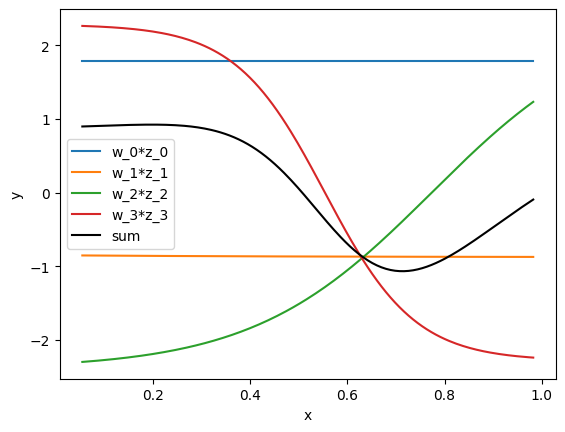

In [129]:
# show snapshots of hidden node evolution
iNNa = 500
z0_a_Plot = np.zeros((np.size(xfitNN),2))
z1_a_Plot = np.zeros((np.size(xfitNN),2))
z2_a_Plot = np.zeros((np.size(xfitNN),2))
z3_a_Plot = np.zeros((np.size(xfitNN),2))
sum_a_Plot = np.zeros((np.size(xfitNN),2))

iNNb = 5000
z0_b_Plot = np.zeros((np.size(xfitNN),2))
z1_b_Plot = np.zeros((np.size(xfitNN),2))
z2_b_Plot = np.zeros((np.size(xfitNN),2))
z3_b_Plot = np.zeros((np.size(xfitNN),2))
sum_b_Plot = np.zeros((np.size(xfitNN),2))

iNNc = 50000
z0_c_Plot = np.zeros((np.size(xfitNN),2))
z1_c_Plot = np.zeros((np.size(xfitNN),2))
z2_c_Plot = np.zeros((np.size(xfitNN),2))
z3_c_Plot = np.zeros((np.size(xfitNN),2))
sum_c_Plot = np.zeros((np.size(xfitNN),2))


for i in range(np.size(xfitNN)):
    z0_a_Plot[i] = np.array((xfitNN[i],w2Rec[iNNa,0]))
    z1_a_Plot[i] = np.array((xfitNN[i],w2Rec[iNNa,1]*np.tanh(w1Rec[iNNa,0,0]+(w1Rec[iNNa,1,0]*xfitNN[i]))))
    z2_a_Plot[i] = np.array((xfitNN[i],w2Rec[iNNa,2]*np.tanh(w1Rec[iNNa,0,1]+(w1Rec[iNNa,1,1]*xfitNN[i]))))
    z3_a_Plot[i] = np.array((xfitNN[i],w2Rec[iNNa,3]*np.tanh(w1Rec[iNNa,0,2]+(w1Rec[iNNa,1,2]*xfitNN[i]))))
    sum_a_Plot[i] = np.array((xfitNN[i],yhatNN(xfitNN[i],w1Rec[iNNa],w2Rec[iNNa])))

    z0_b_Plot[i] = np.array((xfitNN[i],w2Rec[iNNb,0]))
    z1_b_Plot[i] = np.array((xfitNN[i],w2Rec[iNNb,1]*np.tanh(w1Rec[iNNb,0,0]+(w1Rec[iNNb,1,0]*xfitNN[i]))))
    z2_b_Plot[i] = np.array((xfitNN[i],w2Rec[iNNb,2]*np.tanh(w1Rec[iNNb,0,1]+(w1Rec[iNNb,1,1]*xfitNN[i]))))
    z3_b_Plot[i] = np.array((xfitNN[i],w2Rec[iNNb,3]*np.tanh(w1Rec[iNNb,0,2]+(w1Rec[iNNb,1,2]*xfitNN[i]))))
    sum_b_Plot[i] = np.array((xfitNN[i],yhatNN(xfitNN[i],w1Rec[iNNb],w2Rec[iNNb])))

    z0_c_Plot[i] = np.array((xfitNN[i],w2Rec[iNNc,0]))
    z1_c_Plot[i] = np.array((xfitNN[i],w2Rec[iNNc,1]*np.tanh(w1Rec[iNNc,0,0]+(w1Rec[iNNc,1,0]*xfitNN[i]))))
    z2_c_Plot[i] = np.array((xfitNN[i],w2Rec[iNNc,2]*np.tanh(w1Rec[iNNc,0,1]+(w1Rec[iNNc,1,1]*xfitNN[i]))))
    z3_c_Plot[i] = np.array((xfitNN[i],w2Rec[iNNc,3]*np.tanh(w1Rec[iNNc,0,2]+(w1Rec[iNNc,1,2]*xfitNN[i]))))
    sum_c_Plot[i] = np.array((xfitNN[i],yhatNN(xfitNN[i],w1Rec[iNNc],w2Rec[iNNc])))

# make plots
plt.plot(z0_a_Plot[:,0],z0_a_Plot[:,1], label='w_0*z_0')
plt.plot(z1_a_Plot[:,0],z1_a_Plot[:,1], label='w_1*z_1')
plt.plot(z2_a_Plot[:,0],z2_a_Plot[:,1], label='w_2*z_2')
plt.plot(z3_a_Plot[:,0],z3_a_Plot[:,1], label='w_3*z_3')
plt.plot(sum_a_Plot[:,0],sum_a_Plot[:,1], label='sum', color='black')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='best')
plt.show() 

plt.plot(z0_b_Plot[:,0],z0_b_Plot[:,1], label='w_0*z_0')
plt.plot(z1_b_Plot[:,0],z1_b_Plot[:,1], label='w_1*z_1')
plt.plot(z2_b_Plot[:,0],z2_b_Plot[:,1], label='w_2*z_2')
plt.plot(z3_b_Plot[:,0],z3_b_Plot[:,1], label='w_3*z_3')
plt.plot(sum_b_Plot[:,0],sum_b_Plot[:,1], label='sum', color='black')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='best')
plt.show() 

plt.plot(z0_c_Plot[:,0],z0_c_Plot[:,1], label='w_0*z_0')
plt.plot(z1_c_Plot[:,0],z1_c_Plot[:,1], label='w_1*z_1')
plt.plot(z2_c_Plot[:,0],z2_c_Plot[:,1], label='w_2*z_2')
plt.plot(z3_c_Plot[:,0],z3_c_Plot[:,1], label='w_3*z_3')
plt.plot(sum_c_Plot[:,0],sum_c_Plot[:,1], label='sum', color='black')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='best')
plt.show()
